# Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from gensim.models.wrappers import FastText
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounting Google Drive locally

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/DS102'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/CNN


# Importing the dataset

In [3]:
dataset = pd.read_csv('./clean_data/cleaned_data.csv')

In [4]:
def remove_(text):
    return text.replace('_', ' ')

dataset['comment'] = dataset['comment'].apply(lambda x: remove_(x))

# Split the data into training, validation & test sets

In [5]:
X = dataset.loc[:, 'comment'].values
Y = dataset.loc[:, 'label'].values

X_data, X_test, Y_data, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, train_size=0.9, random_state=42, stratify=Y_data)

One Hot Encoder

In [6]:
Y_train = keras.utils.to_categorical(Y_train, num_classes=3)
Y_val = keras.utils.to_categorical(Y_val, num_classes=3)
Y_test = keras.utils.to_categorical(Y_test, num_classes=3)

# Create a vocabulary index

In [7]:
max_tokens = 20000
output_sequence_length = 200
vectorizer = TextVectorization(
    max_tokens=max_tokens, output_sequence_length=output_sequence_length)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [8]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(2, len(voc))))

# Load pre-trained word embeddings

Download pre-trained Fasttext embeddings

In [9]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.bin.gz
!gunzip cc.vi.300.bin.gz

--2020-07-16 12:21:03--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4504817955 (4.2G) [application/octet-stream]
Saving to: ‘cc.vi.300.bin.gz’

cc.vi.300.bin.gz    100%[===================>]   4.20G  22.4MB/s    in 3m 13s  

2020-07-16 12:24:17 (22.2 MB/s) - ‘cc.vi.300.bin.gz’ saved [4504817955/4504817955]



In [10]:
model = FastText.load_fasttext_format('./cc.vi.300.bin')

embeddings_index = {}
for word in model.wv.vocab.keys():
    embeddings_index[word] = model.wv[word]

del(model)
print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


In [11]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word.decode("utf-8"))
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2194 words (96 misses)


In [12]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=output_sequence_length,
    trainable=True,
)

# Build the model

In [13]:
int_sequences_input = keras.Input(shape=(output_sequence_length,))
embedded_sequences = embedding_layer(int_sequences_input)

x = layers.SpatialDropout1D(0.7)(embedded_sequences)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

preds = layers.Dense(3, activation='sigmoid')(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 300)          688200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 128)          115328    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

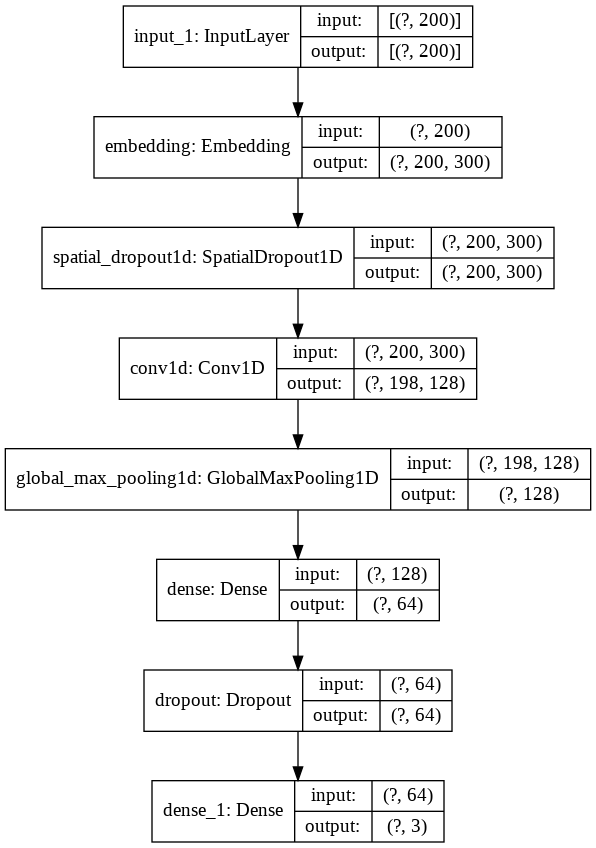

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train the model

In [15]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_val = vectorizer(np.array([[s] for s in X_val])).numpy()

Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

In [16]:
filepath = "model.{epoch:03d}-{val_acc:.3f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val), verbose=2, callbacks=[checkpoint])

Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to model.001-0.500.hdf5
39/39 - 2s - loss: 0.6393 - acc: 0.4025 - val_loss: 0.6211 - val_acc: 0.5000
Epoch 2/100

Epoch 00002: val_acc improved from 0.50000 to 0.57353, saving model to model.002-0.574.hdf5
39/39 - 1s - loss: 0.6002 - acc: 0.5082 - val_loss: 0.5895 - val_acc: 0.5735
Epoch 3/100

Epoch 00003: val_acc improved from 0.57353 to 0.64706, saving model to model.003-0.647.hdf5
39/39 - 2s - loss: 0.5507 - acc: 0.5943 - val_loss: 0.5603 - val_acc: 0.6471
Epoch 4/100

Epoch 00004: val_acc did not improve from 0.64706
39/39 - 1s - loss: 0.5094 - acc: 0.6434 - val_loss: 0.5138 - val_acc: 0.6029
Epoch 5/100

Epoch 00005: val_acc improved from 0.64706 to 0.66176, saving model to model.005-0.662.hdf5
39/39 - 2s - loss: 0.4585 - acc: 0.6697 - val_loss: 0.4682 - val_acc: 0.6618
Epoch 6/100

Epoch 00006: val_acc improved from 0.66176 to 0.67647, saving model to model.006-0.676.hdf5
39/39 - 2s - loss: 0.4248 - ac

# Load the best model & evaluate

In [17]:
model = keras.models.load_model('./Model/CNN.hdf5')

In [18]:
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

Y_test = np.array(Y_test)

In [19]:
results = model.evaluate(X_val, Y_val, batch_size=32)
print('Val set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(results[0], results[1]))

results = model.evaluate(X_test, Y_test, batch_size=32)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(results[0], results[1]))

5/5 [==============================] - 0s 3ms/step - loss: 0.3917 - acc: 0.7426
Val set
  Loss: 0.392
  Accuracy: 0.743
11/11 [==============================] - 0s 4ms/step - loss: 0.3784 - acc: 0.7640
Test set
  Loss: 0.378
  Accuracy: 0.764


In [20]:
def makeConfusionMatrix(model, X_, Y_, categories=[], sum_stats=True, title=None, avge='macro', ohe=False):
    if ohe:
        y_true = np.argmax(Y_, axis=1)
        y_pred = np.argmax(model.predict(X_), axis=1)
    else:
        y_true = Y_
        y_pred = model.predict(X_)
    cm = confusion_matrix(y_true, y_pred)
    if sum_stats:
        accuracy_metric = accuracy_score(y_true, y_pred)
        precision_metric = precision_score(y_true, y_pred, average=avge)
        recall_metric = recall_score(y_true, y_pred, average=avge)
        f1_metric = f1_score(y_true, y_pred, average=avge)
        stats_text = '\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}'.format(
            accuracy_metric, precision_metric, recall_metric, f1_metric)
    else:
        stats_text = ''
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=categories, yticklabels=categories, annot_kws={'size': 15})
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)
    plt.title(title)

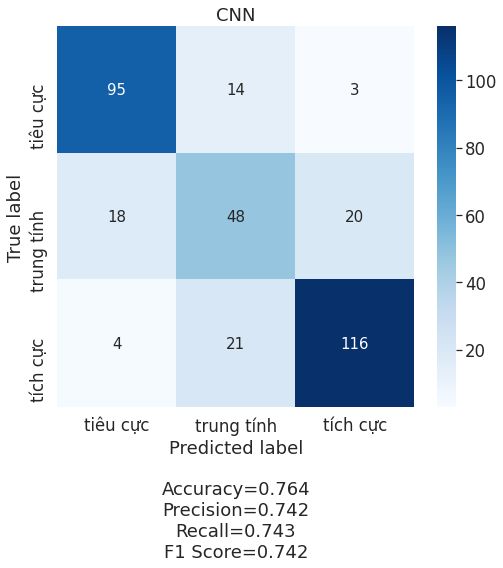

In [21]:
plt.figure(figsize=(8, 7))
sns.set(font_scale=1.5)
makeConfusionMatrix(model, X_test, Y_test, ['tiêu cực', 'trung tính', 'tích cực'], title='CNN', ohe=True)
plt.savefig('confusion_matrix.png')
plt.show()